<a href="https://colab.research.google.com/github/lucchaves/women-in-tech/blob/master/COL_Women_Seen_From_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Women: Seen from Machine Learning**



## Preliminar steps
Import the packages and modules required for the notebook



In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,f1_score,log_loss
from sklearn.feature_selection import SelectFromModel

import pandas as pd
import numpy as np
import scipy.stats  as stats
import statsmodels.api as sm
import xgboost as xgb

pd.set_option("display.max_rows", 300)
pd.set_option('display.max_colwidth', -1)

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1RXFrsH4JwNV3oQhMzT9u7aIy87qoGqXf"}) 
downloaded.GetContentFile('individual_women_data_COL.csv')

## Auxiliar functions

In [0]:
def plot_chart(df, x_col, y_col, axis_x_name, axis_y_name, chart_title):
    plt.style.use('ggplot')

    x = df[x_col].tolist()
    counts = df[y_col].tolist()

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, counts, color='green')
    plt.xlabel(axis_x_name)
    plt.ylabel(axis_y_name)
    plt.title(chart_title)

    plt.xticks(x_pos, x)
    
    plt.xticks(rotation=45, ha='right')

    rcParams['xtick.major.pad']='5'
    plt.show()

In [0]:
def df_summary(data):
  res = []
  for c in data.columns:
      res.append([c, data[c].isna().sum(), len(data[c].unique().tolist()), data[c].unique().tolist()])
                  
  nans = pd.DataFrame(res, columns=['column_name', 'count', 'distinct_values', 'values']).sort_values(['count'], ascending = False)
  nans['pct'] = (nans['count']/len(data)) * 100

  return nans[['column_name', 'distinct_values', 'count', 'pct', 'values']]

## Data Ingestion
### **About the data**
The data used for this investigation was provided by *The DHS Program (Demographic and Health Surveys)*. It consists on a Survey with the following characteristics:
* **Country:** Colombia
* **Fieldwork:**	February 2015 - March 2016

Respondents:
* **Households:**	44,614
* **Female:**	38,718 [Age: 13 to 49]
* **Male:** 35,783 [Age: 13 to 59]


Some of the topics covered by the survey are:
* Abortion
* Alcohol consumption
* Birth registration
* Domestic violence
* Early childhood education
* Women's status

Find more information here: [DHS Program - Colombia: Standard DHS, 2015](https://dhsprogram.com/what-we-do/survey/survey-display-476.cfm)


This dataset was already ingested, filtered by gender and contains preselected features that we found interesting for this investigation

In [0]:
data_raw = pd.read_csv("individual_women_data_COL.csv")
data_raw = data_raw.replace(r'\\n','', regex=True) 
data_raw = data_raw.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [0]:
len(data_raw)

38718

In [0]:
data_raw.head()

,CASEID,current_occupation,occupation_area,department,gender,level_school_completed,mother_marital_stat_when_12_14,father_marital_stat_when_12-14,who_lived_with_when_12-14,all_siblings_same_father,all_siblings_same_mother,age_at_first_child,age_father_at_first_child,reason_for_not_getting_pregnant,has_ever_worked,final_say_on_studying,partner_didnt_allow_to_study_work,pregnancy_test_req_when_looking_for_job,sterilization_prove_req_when_looking_for_job,fired_becaused_pregnancy,reason_stop_school,knows_read_and_write,lives_with,afraid_to_tell_partner_about_pregnancy,forced_to_use_contraception_exhusband,forced_to_use_contraception_boyfriend,forced_to_use_contraception_exboyfriend,forced_to_use_contraception_husband,pressure_from_friends_to_have_sex,final_say_on_having_sex,partner_jealous_place,didnt_allow_see_friends_place,limit_family_contact_place,threaten_with_weapon_place,threaten_to_leave_you_place,threaten_to_take_away_children_place,shake_you_place,slap_you_place,hit_you_with_object_place,kick_you_place,attack_with_a_knife_gun_place,tried_to_strangle_burn_place,partner_threaten_withdraw_economic_support,partner_spent_hh_money,partner_take_away_money_or_real_state,controlling_money_place,threaten_withdraw_economic_support_place,didnt_allow_study_work_place,forced_perform_sexual_acts_place,partner_requested_interruption_pregnacy,considered_separating_from_partner_last_12months,reasons_for_wanting_separate_from_partner,didnt_allow_to_see_friends_boyfriend,didnt_allow_to_see_friends_exboyfriend,limit_contact_with_family_boyfriend,limit_contact_with_family_exboyfriend,dressed_you_bad_terms_boyfriend,dressed_you_bad_terms_exboyfriend,forced_by_partner_to_have_sexual_intercourse,forced_to_perform_sexual_acts_expartner,forced_to_perform_sexual_acts_boyfriend,forced_to_perform_sexual_acts_exboyfriend,agrees_most_important_for_women_take_care_house,agrees_men_are_head_of_hh,agrees_women_are_free_to_decide_if_want_to_work,agrees_on_its_normal_men_dont_allow_wives_go_out_alone,would_call_attention_of_friend_who_verbally_abuse_woman,received_information_on_sexual_related_topics,agrees_on_sometimes_is_right_to_hit_women,agrees_on_take_care_children_is_women_responsibility,agrees_on_men_has_last_word_on_hh_decisions,agrees_on_women_need_men_to_be_happy,agrees_on_families_with_a_man_have_less_problems
0,00011215 1,Administrative personnel (similar employment),Clerical,La Guajira,Female,Technical professional (after high school),NaN,NaN,NaN,NaN,NaN,24.0,26.0,NaN,NaN,No one,No,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00011215 3,"Merchant, vendors",Sales,La Guajira,Female,Professional (towards bachelor degree),NaN,NaN,NaN,NaN,NaN,21.0,23.0,NaN,Yes,Respondent alone,NaN,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00011215 5,Not working and have never worked,Not working,La Guajira,Female,Professional (towards bachelor degree),Living with partner,Living with partner,Others different from father and mother,Yes,Yes,NaN,NaN,NaN,No,Respondent alone,NaN,No,No,Never pregnant/never worked while pregnant,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00011317 2,"Professional, technical (similar employment)",Professional/technical/managerial,La Guajira,Female,Professional (towards bachelor degree),NaN,NaN,NaN,NaN,NaN,26.0,28.0,NaN,NaN,Respondent and husband/partner,No,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,NaN,Respondent alone,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,Private,NaN,NaN,NaN,NaN,No,NaN

## Data Exploration

For a better understanding of the data, some features were selected to see the distribution.

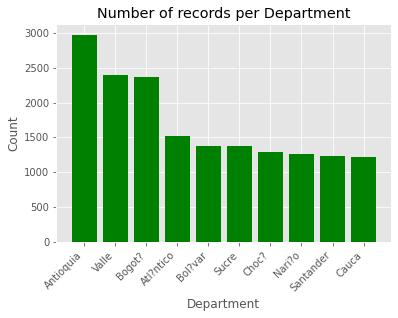

,department,count
1,Antioquia,2980
30,Valle,2401
4,Bogot?,2368
3,Atl?ntico,1526
5,Bol?var,1374
28,Sucre,1372
13,Choc?,1285
21,Nari?o,1261
27,Santander,1238
11,Cauca,1221


In [0]:
department = data_raw.groupby(['department']).size().reset_index(name='count').sort_values(by=['count'], ascending=False).head(10)
plot_chart(department, 'department', 'count', 'Department', 'Count', 'Number of records per Department')
display(department)

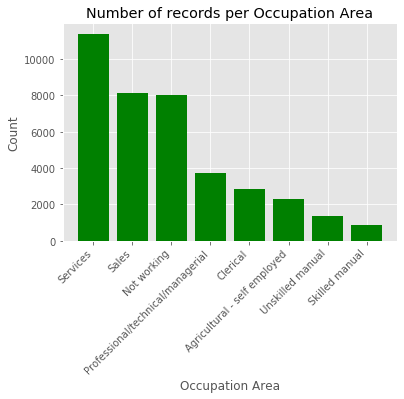

,occupation_area,count
5,Services,11396
4,Sales,8153
2,Not working,8023
3,Professional/technical/managerial,3726
1,Clerical,2831
0,Agricultural - self employed,2314
7,Unskilled manual,1385
6,Skilled manual,890


In [0]:
occupation_area = data_raw.groupby(['occupation_area']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
plot_chart(occupation_area, 'occupation_area', 'count', 'Occupation Area', 'Count', 'Number of records per Occupation Area')
display(occupation_area)

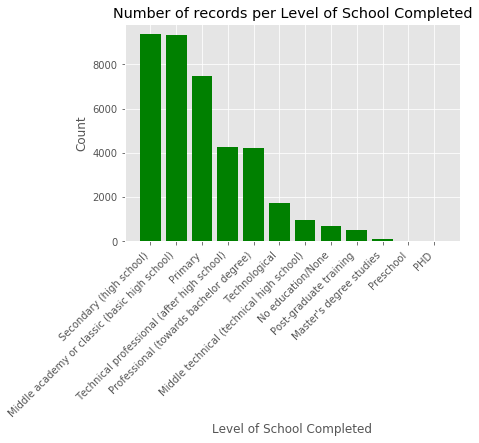

,level_school_completed,count
9,Secondary (high school),9367
1,Middle academy or classic (basic high school),9346
7,Primary,7477
10,Technical professional (after high school),4265
8,Professional (towards bachelor degree),4215
11,Technological,1741
2,Middle technical (technical high school),973
3,No education/None,700
5,Post-graduate training,493
0,Master's degree studies,124


In [0]:
level_school_completed = data_raw.groupby(['level_school_completed']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
plot_chart(level_school_completed, 'level_school_completed', 'count', 'Level of School Completed', 'Count', 'Number of records per Level of School Completed')
display(level_school_completed)

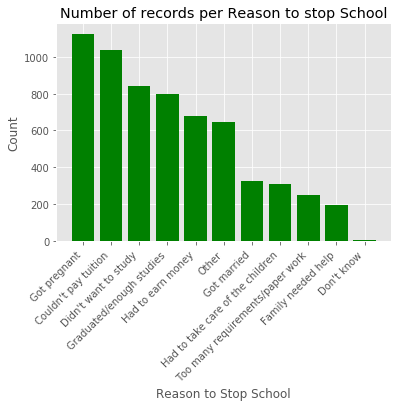

,reason_stop_school,count
5,Got pregnant,1126
0,Couldn't pay tuition,1038
1,Didn't want to study,840
6,Graduated/enough studies,798
7,Had to earn money,676
9,Other,647
4,Got married,327
8,Had to take care of the children,309
10,Too many requirements/paper work,251
3,Family needed help,195


In [0]:
reason_stop_school = data_raw.groupby(['reason_stop_school']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
plot_chart(reason_stop_school, 'reason_stop_school', 'count', 'Reason to Stop School', 'Count', 'Number of records per Reason to stop School')
display(reason_stop_school)

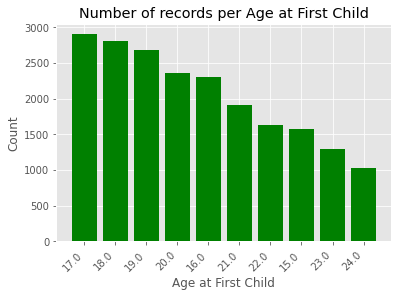

,age_at_first_child,count
7,17.0,2902
8,18.0,2816
9,19.0,2685
10,20.0,2364
6,16.0,2304
11,21.0,1907
12,22.0,1634
5,15.0,1574
13,23.0,1290
14,24.0,1034


In [0]:
age_at_first_child = data_raw.groupby(['age_at_first_child']).size().reset_index(name='count').sort_values(by=['count'], ascending=False).head(10)
plot_chart(age_at_first_child, 'age_at_first_child', 'count', 'Age at First Child', 'Count', 'Number of records per Age at First Child')
display(age_at_first_child)

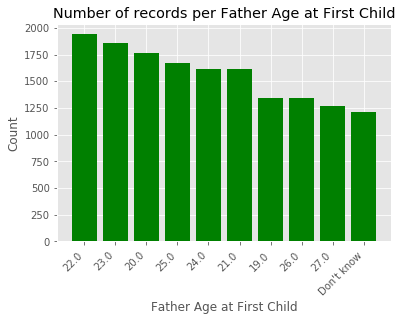

,age_father_at_first_child,count
9,22.0,1939
10,23.0,1857
7,20.0,1761
12,25.0,1675
11,24.0,1619
8,21.0,1612
6,19.0,1344
13,26.0,1343
14,27.0,1266
57,Don't know,1213


In [0]:
age_father_at_first_child = data_raw.groupby(['age_father_at_first_child']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
plot_chart(age_father_at_first_child.head(10), 'age_father_at_first_child', 'count', 'Father Age at First Child', 'Count', 'Number of records per Father Age at First Child')
display(age_father_at_first_child.head(15))

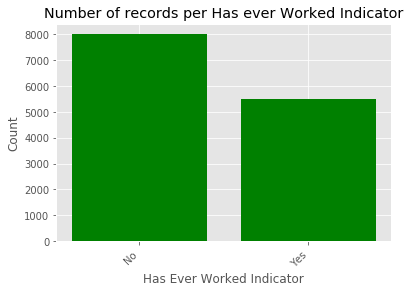

,has_ever_worked,count
0,No,8023
1,Yes,5485


In [0]:
has_ever_worked = data_raw.groupby(['has_ever_worked']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
plot_chart(has_ever_worked.head(10), 'has_ever_worked', 'count', 'Has Ever Worked Indicator', 'Count', 'Number of records per Has ever Worked Indicator')
display(has_ever_worked)

## Define target column 
The target will be women who have suffered some type of abuse, a dummy variable is made with 1s if the women was abused in any way and 0s if she wasn't


In [0]:
data_raw['target'] = np.where((data_raw['partner_didnt_allow_to_study_work'].isin(['Yes, before last year', 'Yes, last year'])) | \
                              (data_raw['fired_becaused_pregnancy'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_exhusband'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_boyfriend'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_exboyfriend'] == 'Yes') | \
                              (data_raw['forced_to_use_contraception_husband'] == 'Yes') | \
                              (data_raw['final_say_on_having_sex'].isin(['Husband/partner alone', 'Someone else'])) | \
                              (data_raw['didnt_allow_see_friends_place'].notnull()) | \
                              (data_raw['limit_family_contact_place'].notnull()) | \
                              (data_raw['threaten_with_weapon_place'].notnull()) | \
                              (data_raw['threaten_to_leave_you_place'].notnull()) | \
                              (data_raw['threaten_to_take_away_children_place'].notnull()) | \
                              (data_raw['shake_you_place'].notnull()) | \
                              (data_raw['slap_you_place'].notnull()) | \
                              (data_raw['hit_you_with_object_place'].notnull()) | \
                              (data_raw['kick_you_place'].notnull()) | \
                              (data_raw['attack_with_a_knife_gun_place'].notnull()) | \
                              (data_raw['tried_to_strangle_burn_place'].notnull()) | \
                              (data_raw['partner_threaten_withdraw_economic_support'].isin(['Yes, before last year', 'Yes, last year'])) | \
                              (data_raw['controlling_money_place'].notnull()) | \
                              (data_raw['threaten_withdraw_economic_support_place'].notnull()) | \
                              (data_raw['forced_perform_sexual_acts_place'].notnull()) | \
                              (data_raw['partner_requested_interruption_pregnacy'] == 'Yes') | \
                              (data_raw['didnt_allow_to_see_friends_boyfriend'] == 'Yes') | \
                              (data_raw['didnt_allow_to_see_friends_exboyfriend'] == 'Yes') | \
                              (data_raw['limit_contact_with_family_boyfriend'] == 'Yes') | \
                              (data_raw['limit_contact_with_family_exboyfriend'] == 'Yes') | \
                              (data_raw['forced_by_partner_to_have_sexual_intercourse'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_expartner'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_boyfriend'] == 'Yes') | \
                              (data_raw['forced_to_perform_sexual_acts_exboyfriend'] == 'Yes'), 1, 0)

Then, drop the features that were use to define the target, so they don't interfere with the fitment of the model 

In [0]:
data = data_raw.drop(['CASEID', 'gender'], axis=1)
target_features = ['partner_didnt_allow_to_study_work', 
                   'fired_becaused_pregnancy', 
                   'forced_to_use_contraception_exhusband',
                   'forced_to_use_contraception_boyfriend',
                   'forced_to_use_contraception_exboyfriend',
                   'forced_to_use_contraception_husband',
                   'final_say_on_having_sex', 'didnt_allow_see_friends_place',
                   'limit_family_contact_place', 'threaten_with_weapon_place',
                   'threaten_to_leave_you_place', 
                   'threaten_to_take_away_children_place', 'shake_you_place', 
                   'slap_you_place', 'hit_you_with_object_place', 
                   'kick_you_place', 'attack_with_a_knife_gun_place',
                   'tried_to_strangle_burn_place', 
                   'partner_threaten_withdraw_economic_support', 
                   'controlling_money_place', 
                   'threaten_withdraw_economic_support_place',
                   'forced_perform_sexual_acts_place',
                   'partner_requested_interruption_pregnacy',
                   'didnt_allow_to_see_friends_boyfriend',
                   'didnt_allow_to_see_friends_exboyfriend',
                   'limit_contact_with_family_boyfriend',
                   'limit_contact_with_family_exboyfriend',
                   'forced_by_partner_to_have_sexual_intercourse',
                   'forced_to_perform_sexual_acts_expartner',
                   'forced_to_perform_sexual_acts_boyfriend',
                   'forced_to_perform_sexual_acts_exboyfriend']

data = data.drop(target_features, axis=1)

The size of the resulting target is as follows:


In [0]:
display(data.groupby(['target']).size().reset_index(name='counts'))

,target,counts
0,0,23260
1,1,15458


It shows that the target is balanced enough, since the percentage of 1s is 39.92% of the overall observations. But, this means that almost 40% among the women surveyed has experienced some kind of abuse, which is an alarming number.

## Data Wrangling 
The data is prepared to be used in the model

### Recode features
Replace string values with numeric values

In [0]:
data = data.replace({'department': {'Amazonas': 1, 'Antioquia': 2, 'Arauca': 3, 'Atl?ntico': 4,
                                    'Bogot?': 5, 'Bol?var': 6, 'Boyac?': 7, 'C?rdoba': 8, 'Caldas': 9,
                                    'Caquet?': 10, 'Casanare': 11, 'Cauca': 12, 'Cesar': 13, 'Choc?': 14,
                                    'Cundinamarca': 15, 'Guain?a': 16, 'Guaviare': 17, 'Huila': 18, 'Magdalena': 19,
                                    'Meta': 20, 'Nari?o': 21, 'Norte de Santander': 22, 'Putumayo': 23, 'Quind?o': 24,
                                    'Risaralda': 25, 'San Andr?s y Providencia': 26, 'Santander': 27, 'Sucre': 28,
                                    'Tolima': 29, 'Valle': 30, 'Vaup?s': 31, 'Vichada': 32, 'La Guajira': 33}})

### Handling missing values

Add 'NA' as category on the corresponding features, because in some cases the question didn't apply so this isn't really missing data


In [0]:
new_cat = ['afraid_to_tell_partner_about_pregnancy',
           'dressed_you_bad_terms_exboyfriend',	
           'dressed_you_bad_terms_boyfriend', 'partner_jealous_place',
           'considered_separating_from_partner_last_12months',
           'partner_spent_hh_money', 'partner_take_away_money_or_real_state',
           'age_father_at_first_child', 'age_at_first_child',
           'sterilization_prove_req_when_looking_for_job', 'current_occupation',
           'pressure_from_friends_to_have_sex',
           'reasons_for_wanting_separate_from_partner', 
           'didnt_allow_study_work_place', 'occupation_area', 
           'final_say_on_studying', 'level_school_completed', 'department',
           'all_siblings_same_father', 'all_siblings_same_mother',
           'reason_for_not_getting_pregnant']
           
data[new_cat] = data[new_cat].fillna(value='NA')

### Pre-select variables based on NAs %

Create a summary per column with the percentage of NAs, so the features with less missing data are easily chosen

In [0]:
nans = df_summary(data)
nans

,column_name,distinct_values,count,pct,values
18,lives_with,8,35979,92.925771,"[nan, Only with biological mother, Others different from father and mother, Biological father and mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
16,reason_stop_school,12,32506,83.955783,"[nan, Other, Didn't want to study, Got pregnant, Got married, Graduated/enough studies, Couldn't pay tuition, Had to earn money, Too many requirements/paper work, Had to take care of the children, Family needed help, Don't know]"
17,knows_read_and_write,3,30528,78.847048,"[nan, No, Yes]"
4,mother_marital_stat_when_12_14,9,26318,67.973552,"[nan, Living with partner, Separated, Never in union, Married, Deceased, Widowed, Don't know, Divorced]"
5,father_marital_stat_when_12-14,9,26318,67.973552,"[nan, Living with partner, Don't know, Married, Deceased, Separated, Widowed, Never in union, Divorced]"
6,who_lived_with_when_12-14,8,26318,67.973552,"[nan, Others different from father and mother, Biological father and mother, Only with biological mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
33,would_call_attention_of_friend_who_verbally_abuse_woman,5,26075,67.345937,"[nan, Would do it, Has already done it, Wouldn't do it, Refuse to answer]"
32,agrees_on_its_normal_men_dont_allow_wives_go_out_alone,4,26075,67.345937,"[nan, Disagrees, Neither agrees nor disagrees, Agrees]"
34,received_information_on_sexual_related_topics,3,25803,66.643422,"[nan, Yes, No]"
30,agrees_men_are_head_of_hh,4,25803,66.643422,"[nan, Agrees, Neither agrees nor disagrees, Disagrees]"


The variables with less than 67% of missing values were chosen for this model, the missing values are filled with the mode of the respective column

In [0]:
replace_nan = nans[nans['pct'] < 67]['column_name']

for c in replace_nan:
    data[c] = np.where(data[c].isnull(), data[c].mode(), data[c])

### Data Cleaning

There are different types of data in the dataset, first the dummy variables, which are cleaned by putting a 1 if there is a "Yes" and a 0 otherwise.
 

In [0]:
yes_no = ['received_information_on_sexual_related_topics', 'has_ever_worked']

for c in yes_no:
    data[c] = np.where(data[c] == 'Yes', 1, 0)

Then there are categorical ordinal features, the categories of this features can be sorted, so they are replaced by sorted numbers

In [0]:
cat = ['agrees_men_are_head_of_hh', 
       'agrees_women_are_free_to_decide_if_want_to_work', 
       'agrees_most_important_for_women_take_care_house', 
       'agrees_on_sometimes_is_right_to_hit_women', 
       'agrees_on_take_care_children_is_women_responsibility',
       'agrees_on_men_has_last_word_on_hh_decisions', 
       'agrees_on_women_need_men_to_be_happy', 
       'agrees_on_families_with_a_man_have_less_problems', 
       'pregnancy_test_req_when_looking_for_job']
       
all_cat = {}
for column in cat:
  data[column] = data[column].astype(str)
  categories = data[column].unique()
  categories = sorted(categories)
  values = range(1, len(categories)+1)
  cat_dict = dict(zip(categories, values))
  all_cat.update({column:cat_dict})

data = data.replace(all_cat)

Finally, there are categorical nominal features, the order of their categories has no meaning so new dummy variables are created for each category


In [0]:
create_dummies = ['afraid_to_tell_partner_about_pregnancy',
                  'dressed_you_bad_terms_exboyfriend',	
                  'dressed_you_bad_terms_boyfriend', 'partner_jealous_place',
                  'considered_separating_from_partner_last_12months',
                  'partner_spent_hh_money', 
                  'partner_take_away_money_or_real_state',
                  'age_father_at_first_child', 'age_at_first_child',
                  'sterilization_prove_req_when_looking_for_job', 
                  'current_occupation', 'pressure_from_friends_to_have_sex',
                  'reasons_for_wanting_separate_from_partner', 
                  'didnt_allow_study_work_place', 'occupation_area', 
                  'final_say_on_studying', 'level_school_completed', 
                  'all_siblings_same_father', 'all_siblings_same_mother', 
                  'reason_for_not_getting_pregnant']
for column in create_dummies:
    data[column] = data[column].astype(str)
df_dummies = pd.get_dummies(data[create_dummies])
data[df_dummies.columns] = df_dummies
data = data.drop(create_dummies, axis = 1)

The summary is recalculated to make sure all the missing data was filled properly

In [0]:
nans2 = df_summary(data)
nans2

,column_name,distinct_values,count,pct,values
8,lives_with,8,35979,92.925771,"[nan, Only with biological mother, Others different from father and mother, Biological father and mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
6,reason_stop_school,12,32506,83.955783,"[nan, Other, Didn't want to study, Got pregnant, Got married, Graduated/enough studies, Couldn't pay tuition, Had to earn money, Too many requirements/paper work, Had to take care of the children, Family needed help, Don't know]"
7,knows_read_and_write,3,30528,78.847048,"[nan, No, Yes]"
2,father_marital_stat_when_12-14,9,26318,67.973552,"[nan, Living with partner, Don't know, Married, Deceased, Separated, Widowed, Never in union, Divorced]"
3,who_lived_with_when_12-14,8,26318,67.973552,"[nan, Others different from father and mother, Biological father and mother, Only with biological mother, Biological mother and stepfather, Only with biological father, Biological father and stepmother, Alone]"
1,mother_marital_stat_when_12_14,9,26318,67.973552,"[nan, Living with partner, Separated, Never in union, Married, Deceased, Widowed, Don't know, Divorced]"
12,agrees_on_its_normal_men_dont_allow_wives_go_out_alone,4,26075,67.345937,"[nan, Disagrees, Neither agrees nor disagrees, Agrees]"
13,would_call_attention_of_friend_who_verbally_abuse_woman,5,26075,67.345937,"[nan, Would do it, Has already done it, Wouldn't do it, Refuse to answer]"
0,department,33,0,0.000000,"[33, 13, 19, 4, 26, 6, 28, 8, 27, 22, 7, 15, 20, 5, 2, 9, 25, 24, 29, 18, 10, 30, 12, 21, 14, 3, 11, 23, 1, 16, 17, 31, 32]"
141,sterilization_prove_req_when_looking_for_job_NA,2,0,0.000000,"[0, 1]"


Finally, the variables with no missing data are chosen

In [0]:
cols_to_select = nans2[nans2['pct'] == 0]['column_name'].tolist()

## Modeling process

Create dataset for modeling with the features selected before


In [0]:
to_model = data[cols_to_select]

### Feature Selection 


The first step is to calculate the Pearson correlation of each feature with the target feature

In [0]:
cols_to_exclude = ['target'] 

corr_vars = list(to_model.drop(columns=cols_to_exclude).columns.values)

corr_values = []
p_values = []
for col in corr_vars:
    #print(col)
    values = stats.pearsonr(to_model['target'], to_model[col])
    corr_values.append(values[0])
    p_values.append(values[1])

    
corr_with_target = pd.DataFrame({'column_name': corr_vars, 'pearson_corr': corr_values, 'pearson_p_value': p_values})
corr_with_target = corr_with_target.sort_values(by=['pearson_corr'], ascending=False) # Sort values by corr
corr_with_target = corr_with_target.reindex(corr_with_target.pearson_corr.abs().sort_values(ascending=False).index)

corr_with_target['pearson_corr'] = corr_with_target['pearson_corr'].abs()
display(corr_with_target)

,column_name,pearson_corr,pearson_p_value
129,partner_jealous_place_NA,0.539620,0.000000
112,partner_take_away_money_or_real_state_NA,0.442426,0.000000
108,partner_spent_hh_money_NA,0.442426,0.000000
84,didnt_allow_study_work_place_NA,0.395509,0.000000
128,partner_jealous_place_Private,0.373807,0.000000
...,...,...,...
142,afraid_to_tell_partner_about_pregnancy_NA,0.000935,0.853977
194,age_father_at_first_child_41.0,0.000713,0.888425
42,age_at_first_child_32.0,0.000396,0.937908
157,age_father_at_first_child_55.0,0.000030,0.995241


In [0]:
target = to_model['target']
to_model = to_model.drop('target', axis=1)

The features with more than 25% of correlation are chosen for the model

In [0]:
selected_features = corr_with_target[corr_with_target['pearson_corr'] > 0.25]['column_name'].tolist()
print(len(selected_features))
X = to_model[selected_features]

16


### Train and Test data 
The dataset is divided in two, the train dataset that represents 70% of the overall data and is used for fitting the model and the test dataset represents the rest 30% of the whole dataset and is used to validate the model results 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, target,test_size=0.3, random_state=0)

### Fitting model
The model was fitted with the train dataset and using the GLM function from statsmodel module. 

In [0]:
logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result = logit_model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encount

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                27102
Model:                            GLM   Df Residuals:                    27088
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 24 Feb 2020   Deviance:                          nan
Time:                        21:15:56   Pearson chi2:                 2.66e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
partner_jealous_place_NA                                    -2.101e+15   2.34e+06  -8.97e+08      0.000    -2.1e+15    -2.1e+15
partner_take_away_money_or_real_state_NA                    -8.755e+13    1.5e+06  -5.85e+07      0.000   -8.76e+13   -8.76e+13
partner_spent_hh_money_NA                                   -8.755e+13    1.5e+06  -5.85e+07      0.000   -8.76e+13   -8.76e+13
didnt_allow_study_work_place_NA                             -2.929e+15   3.52e+06  -8.32e+08      0.000   -2.93e+15   -2.93e+15
partner_jealous_place_Private                               -1.911e+15   2.32e+06  -8.22e+08      0.000   -1.91e+15   -1.91e+15
partner_take_away_money_or_real_state_No                    -1.439e+15   2.65e+06  -5.42e+08      0.000   -1.44e+15   -1.44e+15
didnt_allow_study_work_place_Private                         5.993e+14   3.66e+06   1.64e+08      0.000    5.99e+14    5.99e+14
reasons_for_wanting_separate_from_partner_NA                 3.891e+15   4.51e+06   8.62e+08      0.000    3.89e+15    3.89e+15
considered_separating_from_partner_last_12months_Yes         4.813e+15   4.76e+06   1.01e+09      0.000    4.81e+15    4.81e+15
age_father_at_first_child_NA                                -1.069e+14   6.92e+05  -1.54e+08      0.000   -1.07e+14   -1.07e+14
age_at_first_child_NA                                       -1.069e+14   6.92e+05  -1.54e+08      0.000   -1.07e+14   -1.07e+14
partner_spent_hh_money_Yes, last year                         1.55e+15   1.73e+06   8.98e+08      0.000    1.55e+15    1.55e+15
reasons_for_wanting_separate_from_partner_Domestic violence  4.377e+14   2.21e+06   1.98e+08      0.000    4.38e+14    4.38e+14
all_siblings_same_mother_NA                                  1.002e+14   1.15e+06   8.69e+07      0.000       1e+14       1e+14
partner_jealous_place_Both public/private                   -6.223e+14   2.82e+06  -2.21e+08      0.000   -6.22e+14   -6.22e+14
pressure_from_friends_to_have_sex_NA                         1.177e+15   1.42e+06   8.27e+08      0.000    1.18e+15    1.18e+15
===============================================================================================================================
"""

### Metrics: Confusion Matrix and Accuracy

In [0]:
y_predtest = result.predict(X_test)
y_predtrain = result.predict(X_train)
y_bintest = [1 if x >= 0.5 else 0 for x in y_predtest]
y_bintrain = [1 if x >= 0.5 else 0 for x in y_predtrain]

#confusion matrix for the train dataset
confusion1 = confusion_matrix(y_train, y_bintrain)
print("Train confusion matrix")
print(confusion1)
print("Accuracy: ", (confusion1[0][0] + confusion1[1][1]) / X_train.shape[0])
    
#confusion matrix for the test dataset
confusion2 = confusion_matrix(y_test, y_bintest)
print("Test confusion matrix")
print(confusion2)
print("Accuracy: ", (confusion2[0][0] + confusion2[1][1]) / X_test.shape[0])

Train confusion matrix
[[15988   360]
 [ 5539  5215]]
Accuracy:  0.7823407866578113
Test confusion matrix
[[6741  171]
 [2406 2298]]
Accuracy:  0.778150826446281


/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


### Metrics: ROC curve and AUC for the test dataset

No handles with labels found to put in legend.


0.731890412414966


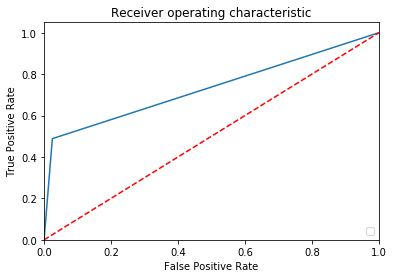

In [0]:
logit_roc_auc = roc_auc_score(y_test, y_predtest)
print(logit_roc_auc)
#The ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predtest)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

### Metrics: F1 Score

In [0]:
print(f1_score(y_train, y_bintrain, average = "binary"))
print(f1_score(y_test, y_bintest, average = "binary"))

0.6387408904403209
0.6407360936846508


### Metrics: Log Loss


In [0]:
print(log_loss(y_train, y_bintrain))
print(log_loss(y_test, y_bintest))

7.517693521092649
7.662410769700878


The model can perform better if a more sofisticated feature selection algorith was used


## Modeling process 2.0

For the upgrade of the model, the feature selection algorithm used was the one provided by the XGBoost module 

In [0]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators= 60, learning_rate=0.05)
embeded_xgb_selector = SelectFromModel(gbm, threshold= 0.004)
embeded_xgb_selector.fit(X_train, y_train)
embeded_xgb_support = embeded_xgb_selector.get_support()
selected_features = X_train.loc[:,embeded_xgb_support].columns.tolist()
print(len(selected_features))
X = to_model[selected_features]


10


After the feature selection, the modeling process is the same as the one done 
before

### Train and Test datasets
The data is again divided in train and test datasets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, target,test_size=0.3, random_state=0)

### Fitting model
The model was fitted with the train dataset and using the GLM function from statsmodel module. 

In [0]:
logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result = logit_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                27102
Model:                            GLM   Df Residuals:                    27092
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12164.
Date:                Mon, 24 Feb 2020   Deviance:                       24328.
Time:                        21:17:12   Pearson chi2:                 2.86e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
partner_jealous_place_NA                                       -0.6934      0.079     -8.740      0.000      -0.849      -0.538
partner_take_away_money_or_real_state_NA                        0.9522      0.110      8.690      0.000       0.737       1.167
didnt_allow_study_work_place_NA                                -1.8182      0.079    -23.065      0.000      -1.973      -1.664
partner_jealous_place_Private                                   0.7005      0.079      8.843      0.000       0.545       0.856
partner_take_away_money_or_real_state_No                        1.8371      0.092     19.967      0.000       1.657       2.017
reasons_for_wanting_separate_from_partner_NA                   -0.2584      0.054     -4.793      0.000      -0.364      -0.153
age_father_at_first_child_NA                                   -0.3960      0.050     -7.993      0.000      -0.493      -0.299
partner_spent_hh_money_Yes, last year                           2.6972      0.106     25.452      0.000       2.489       2.905
reasons_for_wanting_separate_from_partner_Domestic violence     1.7525      0.109     16.062      0.000       1.539       1.966
partner_jealous_place_Both public/private                       2.4481      0.144     17.021      0.000       2.166       2.730
===============================================================================================================================
"""

### Metrics: Confusion Matrix and Accuracy


In [0]:
y_predtest = result.predict(X_test)
y_predtrain = result.predict(X_train)
y_bintest = [1 if x >= 0.5 else 0 for x in y_predtest]
y_bintrain = [1 if x >= 0.5 else 0 for x in y_predtrain]

#confusion matrix for the train dataset
confusion1 = confusion_matrix(y_train, y_bintrain)
print("Train confusion matrix")
print(confusion1)
print("Accuracy: ", (confusion1[0][0] + confusion1[1][1]) / X_train.shape[0])
    
#confusion matrix for the test dataset
confusion2 = confusion_matrix(y_test, y_bintest)
print("Test confusion matrix")
print(confusion2)
print("Accuracy: ", (confusion2[0][0] + confusion2[1][1]) / X_test.shape[0])

Train confusion matrix
[[14393  1955]
 [ 3498  7256]]
Accuracy:  0.7987971367426758
Test confusion matrix
[[6047  865]
 [1489 3215]]
Accuracy:  0.7973484848484849


### Metrics: ROC curve and AUC

No handles with labels found to put in legend.


0.8479390815932855


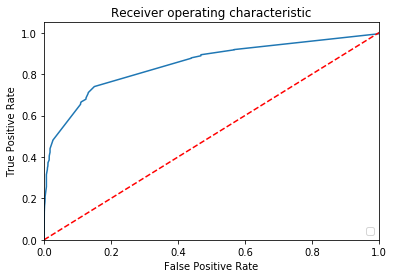

In [0]:
logit_roc_auc = roc_auc_score(y_test, y_predtest)
print(logit_roc_auc)   
#The ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predtest)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

### Metrics: F1 Score

In [0]:
print(f1_score(y_train, y_bintrain, average = "binary"))
print(f1_score(y_test, y_bintest, average = "binary"))

0.7268720260455798
0.7320127504553733


### Metrics: Log Loss

In [0]:
print(log_loss(y_train, y_bintrain))
print(log_loss(y_test, y_bintest))

6.949358382939414
6.999394910932926
